In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

## Data Set

In [2]:
X, y = datasets.make_blobs(n_samples=600,n_features=2, centers=7,cluster_std=1.69,random_state=420)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# K-means
distance measure: euclidean
then the central points are mean average of the distance

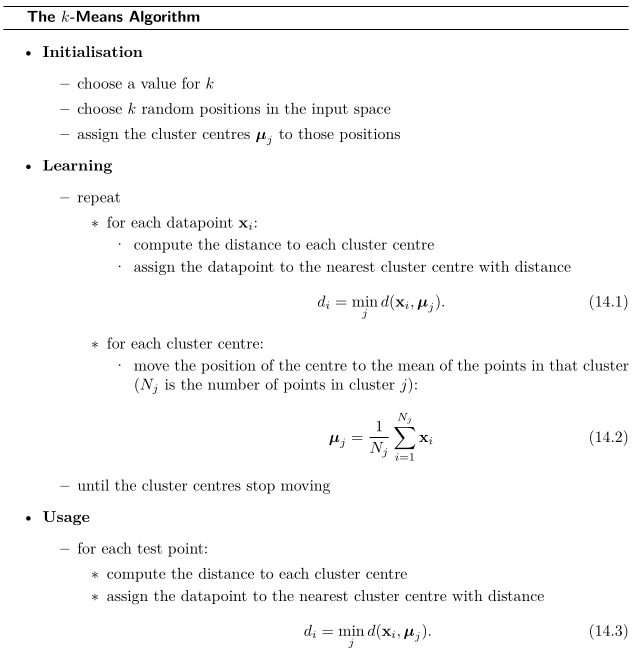

to check weather the centers are moving are not, we can just calculate the distances between previous and current centers, if the sum of the distances equals 0 then the algorithm is converged.

In [3]:
def euclidean(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [4]:
def nearest_center(x,centers):
    distance = [euclidean(x,mu) for mu in centers]
    return np.argmin(distance)

In [5]:
def centers_moved_distance(A,B):
    return sum([euclidean(A[i],B[i]) for i in range(len(B))])

In [6]:
def plot_clusters(clusters,centers,X):
    fig, ax = plt.subplots(figsize=(4, 6))

    for i, index in enumerate(clusters):
        if index:
            point = X[index].T
            ax.scatter(*point)

    for j,mu in enumerate(centers):
        ax.scatter(*mu, color="black", linewidth=.3)
        ax.text(mu[0], mu[1], f"{j+1}", ha="center", va="center", fontsize=22)

    plt.show()

In [7]:
def KMeans(X,K,max_steps=100):
    N = len(X)
    centers = [X[i] for i in np.random.choice(N,K)]
    
    for _ in range(max_steps):
        clusters = [[] for _ in range(K)]
        for i in range(N):
            mu = nearest_center(X[i],centers)
            clusters[mu].append(i)
        
        plot_clusters(clusters,centers,X) # for viz
        
        prev_centers = centers.copy()
        for j,cluster in enumerate(clusters):
            centers[j] = np.mean(X[cluster],axis=0)
            
        if centers_moved_distance(prev_centers,centers) == 0: break # algorithm converged
    return centers 

In [8]:
def find_center(X,centers):
    clusters = [[] for _ in range(len(centers))]
    for i in range(len(X)):
        mu = nearest_center(X[i],centers)
        clusters[mu].append(i)
    plot_clusters(clusters,centers,X)
    return clusters

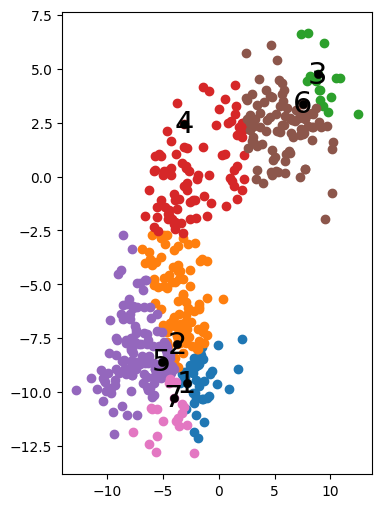

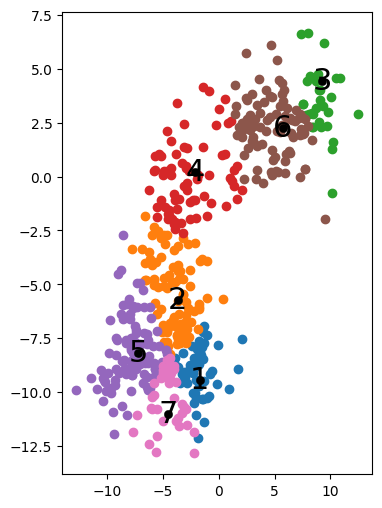

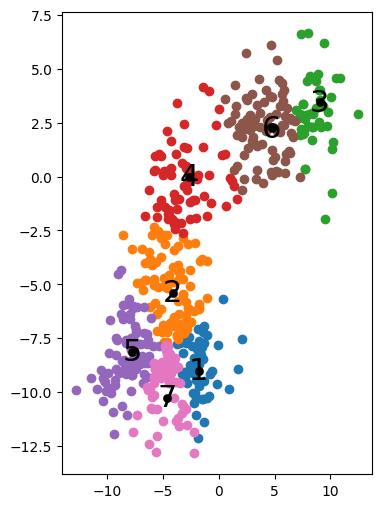

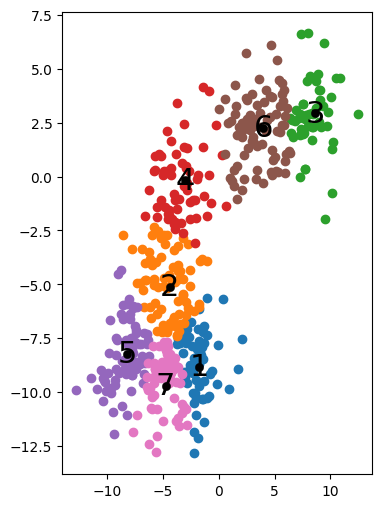

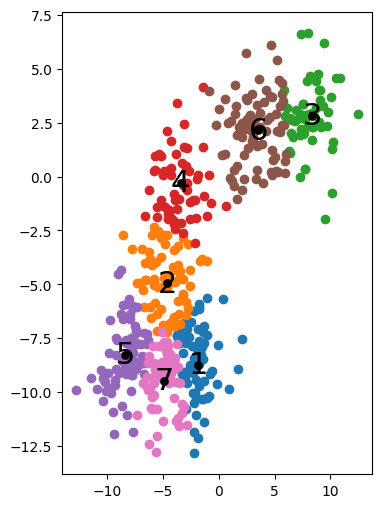

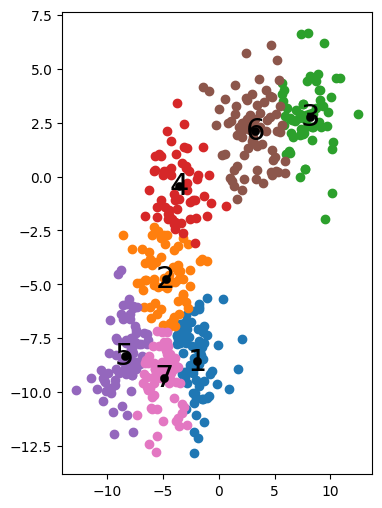

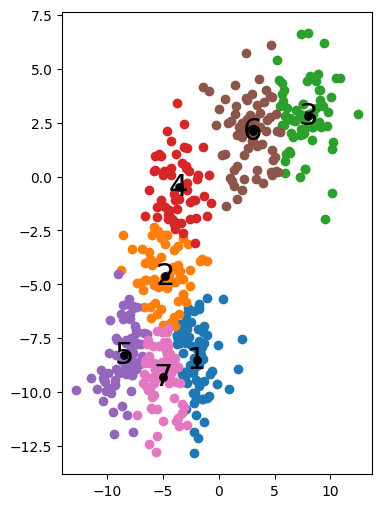

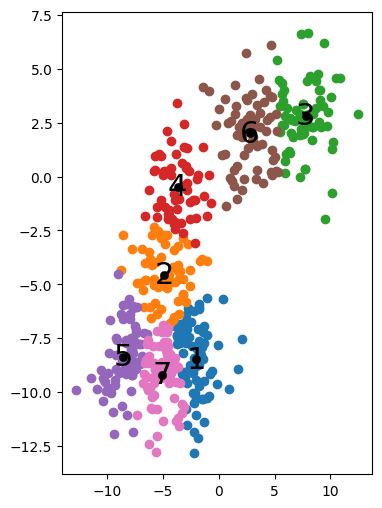

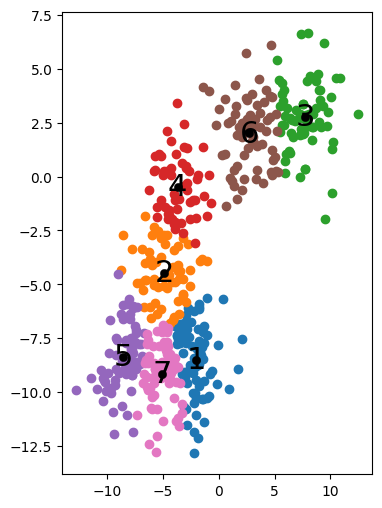

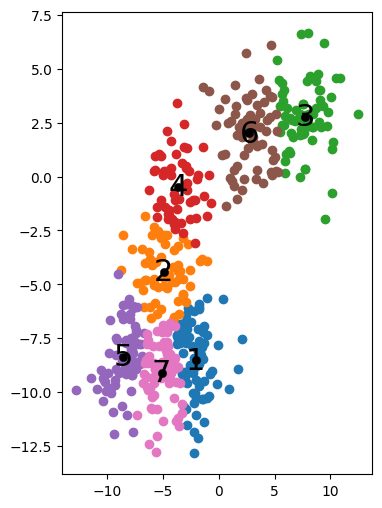

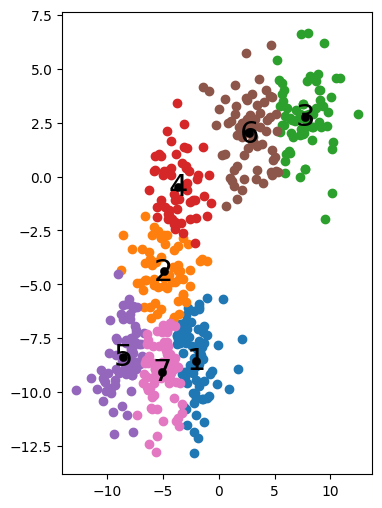

In [9]:
centers = KMeans(X_train,7)

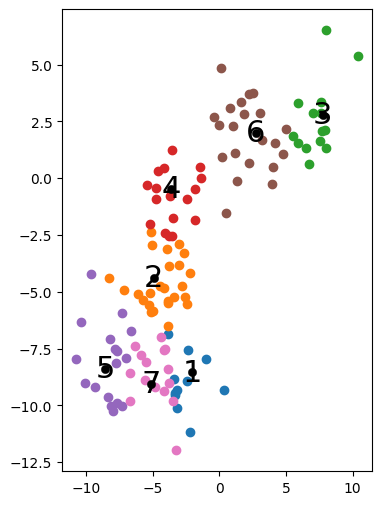

[[6, 11, 22, 35, 46, 59, 61, 71, 74, 89, 111],
 [1,
  5,
  9,
  18,
  23,
  26,
  27,
  32,
  37,
  40,
  42,
  43,
  48,
  54,
  58,
  70,
  79,
  82,
  84,
  88,
  97,
  103,
  106,
  109,
  113],
 [0, 8, 33, 45, 63, 92, 96, 102, 104, 105, 107, 116, 117, 118],
 [3, 17, 20, 21, 36, 38, 44, 57, 72, 75, 78, 85, 86, 90, 91, 95, 98],
 [2, 7, 19, 52, 56, 64, 68, 69, 76, 80, 83, 93, 99, 101, 108, 112, 114],
 [4,
  10,
  12,
  13,
  16,
  25,
  31,
  41,
  49,
  50,
  51,
  53,
  55,
  60,
  62,
  66,
  67,
  73,
  110,
  115,
  119],
 [14, 15, 24, 28, 29, 30, 34, 39, 47, 65, 77, 81, 87, 94, 100]]

In [10]:
find_center(X_test,centers)

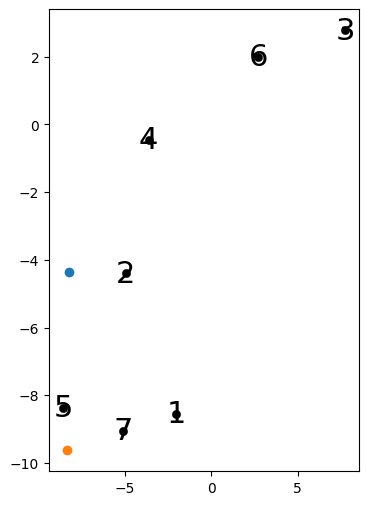

[[], [0], [], [], [1], [], []]

In [11]:
find_center(X_test[1:3,:],centers)

# K Nearest Neighbor
No training is required in KNN, during prediction  $\hat y = argmax_{v \in values(Y)} \sum_{i=1}^K w_i 1(v = y_i)$ where we select K nearest points to the given sample.

For distance measure we use euclidean (or manhattan) distance.
We can have instances contribute to a prediction according to their distance, using inverse distance weighting method. $w_i = \frac 1 {d(x_q,x_i)^p}$ where p is usually 1 or 3,
Epanechnikov or Tricube kernel also can be used for calculating weights.

# KD-Tree (Efficient KNN implimentation)
Its an efficient DS to search KN Data points.
Each internal node stores one instance & splits on the median value of the feature having the highest variance.

In [12]:
import heapq as hq

In [13]:
def ID_weight(d,p):
    return (1/d**p if d != 0 else 1)

def Epanechnikov(d,lam):
    return 0.75*(1-(d**2/lam**2)) if d < lam else 0 

def Tricube(d,lam):
    return (1 - (d/lam)**3)**3 if d < lam else 0

In [14]:
class Node:
    def __init__(self, data,left,right):
        self.left = left
        self.right = right
        self.data = data

In [15]:
class KDTree:
    def __init__(self, X):
        self.X = X
        N,self.M = X.shape
        self.root = self.build(np.array(range(N)))
        
    def build(self, data, depth=0):
        if len(data)==0: return None
        axis = depth % self.M
        data = data[np.argsort(self.X[data,axis])]
        
        median_idx = len(data) // 2
        median = data[median_idx]
        return Node(
            median,
            self.build(data[:median_idx], depth + 1),
            self.build(data[median_idx+1:], depth + 1)
        )

    def query(self, point,K):
        heap = []
        def recursive_search(node, depth):
            if not node: return
            
            axis = depth % len(point)
            if self.X[node.data][axis] <= point[axis]:
                nearer_path = node.right
                further_path = node.left
            else:
                nearer_path = node.left
                further_path = node.right
            recursive_search(nearer_path,depth+1)
            
            distance = euclidean(self.X[node.data],point)
            
            if len(heap) < K: hq.heappush(heap, (-distance,node.data))
            elif distance < -heap[0][0]:
                hq.heappop(heap)
                hq.heappush(heap, (-distance,node.data))
            
            if len(heap) < K or np.abs(point[axis] - self.X[node.data][axis]) < -heap[0][0]:
                recursive_search(further_path,depth+1)
            
            return 
        recursive_search(self.root,0)
        return heap

In [16]:
class KNN:
    def __init__(self,X,y): # Inefficient Brute Force KNN
        self.kdtree = KDTree(X)
        self.y = y
        self.values,_ = np.unique(y, return_counts=True)
        
    def brute_force_KNN(self,s):
        heap = []
        for i in range(self.N):
            distance = euclidean(s,self.X[i])
            if i < self.K: hq.heappush(heap, (-distance,i))
            elif distance < -heap[0][0]:
                hq.heappop(heap)
                hq.heappush(heap, (-distance,i))
        return heap
    
    def predict(self,sample,K=9,weighted=False,kernel=None,kparam=None):
        y_preds = np.zeros(len(sample))
        for j in range(len(sample)):
            # Computing K Nearest Neighbor
            # heap = brute_force_KNN(self,sample[j]) # Brute Force
            heap = self.kdtree.query(sample[j],K) # KD tree
            # Computing weights corresponding to neigbors distance
            k_labels = np.zeros(K)
            k_weights = np.ones(K)
            for i in range(K):
                d,l = heap[i]
                k_labels[i] = self.y[l]
                if weighted: k_weights[i] = kernel(-d,kparam)
            # finding argmax y_hat value
            y_pred = None
            max_wv = float("-inf")
            for v in self.values:
                wv_sum = 0
                for i in range(K):
                    wv_sum += k_weights[i] * (1*(v==k_labels[i]))
                if wv_sum > max_wv:
                    max_wv = wv_sum
                    y_pred = v
            y_preds[j] = y_pred
        return y_preds

In [17]:
model_knn = KNN(X_train,y_train)

In [18]:
K = 9

In [19]:
y_pred = model_knn.predict(X_test,K)
y_pred_idw = model_knn.predict(X_test,K,True,ID_weight,1)
y_pred_E = model_knn.predict(X_test,K,True,Epanechnikov,2)
y_pred_T = model_knn.predict(X_test,K,True,Tricube,2)

In [20]:
print("Miss Classification(Naive):",np.sum(y_pred != y_test),"out off",len(y_test))
print("Miss Classification(IDW):",np.sum(y_pred_idw != y_test),"out off",len(y_test))
print("Miss Classification(E):",np.sum(y_pred_E != y_test),"out off",len(y_test))
print("Miss Classification(T):",np.sum(y_pred_T != y_test),"out off",len(y_test))

Miss Classification(Naive): 36 out off 120
Miss Classification(IDW): 35 out off 120
Miss Classification(E): 33 out off 120
Miss Classification(T): 34 out off 120


# Mixture Models & EM
For a multimodal data we can estimate the parameters for M number of gaussians.

The model is computed as a sum or mixture of the Gaussians together.

Then the output for any particular datapoint that is input to the algorithm will be the sum of the values expected by all of the M Gaussians:
$$
f(x) = \sum^M_{m=1} \alpha_m \phi(x; \mu_m, \Sigma_m),
$$
where $\phi(x; \mu_m, \Sigma_m)$ is a Gaussian function with mean $\mu_m$ and covariance matrix $\Sigma_m$, and the $\alpha_m$ are the weight with the constraint that $\sum_{m=1}^M \alpha_m = 1$.

The probability that input $x_i$ belongs to class m can be written as:
$$
p(x_i \in c_m) = \frac {\hat\alpha_m \phi(x_i; \hat\mu_m, \hat\Sigma_m)} {\sum^M_{k=1} \alpha_m \phi(x_i; \hat\mu_k, \Sigma_k)}
$$
where variabels having(^) means that we are estimating them.

Now we use EM algorithm to find maximum likelihood solution.
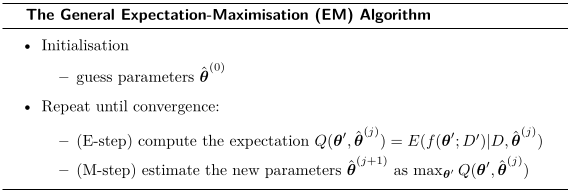


In [21]:
def plot_clusters_g(X, means, covs):
    K = len(means)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
    for k in range(K):
        mean = means[k]
        cov = covs[k]
        plt.plot(mean[0], mean[1], 'ro')
        eigvals, eigvecs = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigvecs[::-1, 0]))
        width, height = 2 * np.sqrt(eigvals)
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='red', alpha=0.2)
        ell.set_facecolor('none')
        plt.gca().add_artist(ell)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Cluster Plot')

    plt.show()

In [ ]:
class GMM:
    def __init__(self, k, max_iter=100):
        self.k = k
        self.max_iter = max_iter
    
    def fit(self, X):
        n_samples, n_features = X.shape
        
        # initialize parameters
        self.pi = np.ones(self.k) / self.k
        self.mu = np.random.rand(self.k, n_features)
        self.cov = np.zeros((self.k, n_features, n_features))
        for i in range(self.k):
            self.cov[i] = np.eye(n_features)
        
        for i in range(self.max_iter):
            # E-step
            r_ic = np.zeros((n_samples, self.k))
            for j in range(self.k):
                pdf = multivariate_normal(self.mu[j], self.cov[j]).pdf(X)
                r_ic[:,j] = self.pi[j] * pdf
            r_ic = r_ic / np.sum(r_ic, axis=1, keepdims=True)
            
            # M-step
            N_c = np.sum(r_ic, axis=0)
            self.pi = N_c / n_samples
            for j in range(self.k):
                self.mu[j] = np.sum(X * r_ic[:,j].reshape(-1,1), axis=0) / N_c[j]
                diff = X - self.mu[j]
                self.cov[j] = np.dot(r_ic[:,j] * diff.T, diff) / N_c[j]
        
    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples)
        for i in range(n_samples):
            probs = np.zeros(self.k)
            for j in range(self.k):
                probs[j] = self.pi[j] * multivariate_normal(self.mu[j], self.cov[j]).pdf(X[i])
            y_pred[i] = np.argmax(probs)
        return y_pred

In [ ]:
em = GMM(7)
em.fit(X_train)
plot_clusters_g(X_train,gmm.mu,gmm.cov)